In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import ast
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# Table of Contents
    1. Import data, initial cleaning and feature engineering
        1.1 Import data
        1.2 Correct datatypes
        1.3 Fill in missing Spotify data
        1.4 Preliminary feature engineering
    2. Feature Summaries
        2.1 Continuous variables
            2.1.1 Summary Stats
            2.1.2 Histograms
            2.1.3 ECDFs
            2.1.4 Outlier Detection
            2.1.4 Conclusions & Questions
        2.2 Categorical Variables
            2.2.1 Countplots
            2.2.2 Conclusions and Questions
            2.2.3 Category Consolidation
    3. Data Exploration
        3.1 Venue State
        3.2 Day of Week
        3.3 Genre and Subgenre
        3.4 Artist Count
        3.5 Promoter
        3.6 Resale Ticket Source

## 1.1 Import data

In [2]:
#Read master dataframe, parsing 
path = 'Data/master_df.csv'
df = pd.read_csv(path,
                 parse_dates=['presale_date_end','presale_date_start','date','TM_sale_date_start'],
                 infer_datetime_format=True,
                 index_col=0)

## 1.2 Correct datatypes

In [3]:
df.dtypes

artists                       object
date                  datetime64[ns]
TM_id                         object
event_title                   object
presale_date_end      datetime64[ns]
presale_date_start    datetime64[ns]
promoter                      object
TM_sale_date_start    datetime64[ns]
span multiple days              bool
venue                         object
TM_venue _lat                 object
venue_city                    object
TM_venue_long                 object
venue_state                   object
TM_max                       float64
TM_min                       float64
genre                         object
subGenre                      object
event_type                    object
SG_artists_score              object
SG_average_price              object
SG_listing_count              object
SG_max_price                  object
SG_min_price                  object
SG_venue_score               float64
SH_max_price                 float64
SH_min_price                 float64
S

In [4]:
#Convert data types to floats and replace 'None' with NaN
df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']] = \
     df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']].replace('None',np.NaN)
df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']] = \
    df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']].astype(float)

#Drop events with no resale or face value tickets    
df.dropna(subset=['SG_min_price','SH_min_price'],how='all',inplace=True)
#df[['SG_max_price','SH_max_price']].dropna(how='all',inplace=True)
df.dropna(subset=['TM_min'],how='any',inplace=True)

#Drop Duplicates
df = df.drop_duplicates(subset='TM_id')

## 1.3 Fill in missing Spotify info with genre medians

In [5]:
# Parse to lists as convert elements to float
def format_spotify_data(cell):
    #Parse list
    cell = ast.literal_eval(cell)
    #Convert to float types
    cell= list(map(float, cell))
    return cell

#Parse strings into lists, convert elements to float
df[['spotify_followers','spotify_popularity']] = \
    df[['spotify_followers','spotify_popularity']].applymap(format_spotify_data)

#Calculate averages for each event
df[['spotify_avg_followers','spotify_avg_popularity']] = \
    df[['spotify_followers','spotify_popularity']].applymap(np.nanmean)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:5043: RuntimeWarning: Mean of empty slice
  return lib.map_infer(x.asobject, func)


In [6]:
#Create dictionaries of genres and median values
popularity_dict = df[['genre','spotify_avg_popularity']].groupby('genre').median()['spotify_avg_popularity'].to_dict()
followers_dict = df[['genre','spotify_avg_followers']].groupby('genre').median()['spotify_avg_followers'].to_dict()

In [7]:
#Map dictionaries to fill in missing values
mask = df['spotify_avg_popularity'].isnull()
df.loc[mask,'spotify_avg_popularity'] = df.loc[mask,'genre'].map(popularity_dict)

mask = df['spotify_avg_followers'].isnull()
df.loc[mask,'spotify_avg_followers'] = df.loc[mask,'genre'].map(followers_dict)

df[['spotify_avg_followers','spotify_avg_popularity']] = \
    df[['spotify_avg_followers','spotify_avg_popularity']].astype(float)

#Create column with count of null artist info
df['spotify_null_count'] = df['spotify_popularity'].map(lambda x: np.isnan(x).sum())

## 1.4 Preliminary feature engineering
Create columns for length of presale, number of days on sale, and days until show

In [8]:
# Create a function to check if source of ticket price was Stubhub, SeatGeek, or both
def ticket_source(row):
    # column order is SH, then SG
    #If SH value is nan, then source is SG
    if np.isnan(row.iloc[0]):
        source = 'SG'
    # Else if SG value is nan then source is SH
    elif np.isnan(row.iloc[1]):
        source = 'SH'
    else:
        source = 'Both'
    return source

#Create a function to check if show has a presale, and calculate days a show has been on sale
def days_on_sale_calc(row):
    if str(row['presale_date_start'])=='NaT':
        days_on_sale = day_zero-row['TM_sale_date_start']
    else: 
        days_on_sale = day_zero-row['presale_date_start']
    return days_on_sale.days

In [9]:
#Create Timestamp of December 7, 2017 -- Date of analysis
day_zero = pd.Timestamp(datetime.datetime(2017, 12, 7))

# Days until show
df['days_until_show'] = (df['date'] - day_zero).dt.days

#Day of the week 
df['day_of_week'] = df['date'].dt.weekday

# Length of presale
df['presale_length'] = (df['presale_date_end']-df['presale_date_start']).dt.total_seconds()/(24*60*60)
df['presale_length'].fillna(0,inplace=True)

# Number of days show has been on sale
df['days_on_sale'] = df[['presale_date_start','TM_sale_date_start']].apply(days_on_sale_calc,axis=1)
df['days_on_sale'].fillna(df['days_on_sale'].median(),inplace=True)

#Count of number of artists per event
df['artist_count'] = df['artists'].dropna().map(lambda x: len(ast.literal_eval(x)))
df['artist_count'].fillna(1,inplace=True)

#Calculate average resale min and max prices from SH and SG
df['avg_resale_min'] = df[['SH_min_price','SG_min_price']].apply( \
    lambda x: np.nanmean(x),axis=1)

df['avg_resale_max'] = df[['SH_max_price','SG_max_price']].apply( \
    lambda x: np.nanmean(x),axis=1)

#Indicate if the avg price is based on SH, SG or joint data
df['min_source'] = df[['SH_min_price','SG_min_price']].apply(ticket_source,axis=1)
df['max_source'] = df[['SH_max_price','SG_max_price']].apply(ticket_source,axis=1)

# Create columns of ticket markup
df['min_markup%'] = np.divide(
    np.subtract(df['avg_resale_min'],df['TM_min']),
    df['TM_min']) * 100
df['max_markup%'] = np.divide(
    np.subtract(df['avg_resale_max'],df['TM_max']),
    df['TM_max']) * 100

#Average SH and SG listings
df['avg_ticket_listings'] = df[['SG_listing_count','SH_total_tickets']].apply( \
    lambda x: np.nanmean(x),axis =1)

## Check for missing values

In [10]:
df.isnull().sum()

artists                      7
date                         0
TM_id                        0
event_title                  0
presale_date_end          1231
presale_date_start        1231
promoter                     0
TM_sale_date_start          74
span multiple days           0
venue                        0
TM_venue _lat                0
venue_city                   0
TM_venue_long                0
venue_state                  0
TM_max                       0
TM_min                       0
genre                        0
subGenre                     0
event_type                   0
SG_artists_score          1838
SG_average_price          1861
SG_listing_count          1861
SG_max_price              1861
SG_min_price              1861
SG_venue_score            1838
SH_max_price              1239
SH_min_price              1239
SH_total_postings         1239
SH_total_tickets          1239
spotify_followers            0
spotify_popularity           0
spotify_avg_followers        0
spotify_


# 2 Summary Statistics

Initial data exploration is divided into two parts- Continuous features and categorical features. </br>

__Continuous Features:__ Ticket prices and markups, ticket and listing counts, time data, and spotify data</br>

__Categorical Features:__ Genres, subgenres, event states, promoters, span multiple days

    2.1 Continuous variables
        2.1.1 Summary Stats
        2.1.2 Histograms
        2.1.3 ECDFs
        2.1.4 Outlier Detection
        2.1.4 Conclusions & Questions
    2.2 Categorical Variables
        2.2.1 Countplots
        2.2.2 Conculsions and Questions
        2.2.3 Category Consolidation

## 2.1.1 Summary Stats

In [11]:
features = {'price_cols': ['TM_min','avg_resale_min','TM_max','avg_resale_max','min_markup%','max_markup%'],
            'ticketlist_cols' : ['avg_ticket_listings'],
            'time_cols' : ['days_on_sale','days_until_show','presale_length'],
            'artist_cols' : ['spotify_avg_followers','spotify_avg_popularity']}
df[features['price_cols']].describe()

,TM_min,avg_resale_min,TM_max,avg_resale_max,min_markup%,max_markup%
count,4464.000000,4464.000000,4464.000000,4.464000e+03,4464.000000,4.464000e+03
mean,37.939108,98.135093,103.168609,3.655692e+03,158.683945,6.044891e+03
std,20.026611,198.279126,229.115055,9.437121e+04,303.890862,2.291474e+05
min,2.500000,6.000000,6.000000,2.300000e+01,-89.855072,-9.438000e+01
25%,25.000000,51.881250,32.000000,2.245000e+02,74.739158,2.388493e+02
50%,35.000000,70.900000,63.650000,4.466850e+02,101.958610,6.063976e+02
75%,47.000000,94.900000,103.000000,6.648350e+02,147.081349,1.394838e+03
max,356.000000,3602.500000,9691.000000,6.000266e+06,6579.000000,1.519045e+07


In [12]:
df['avg_ticket_listings'].describe()

count    4464.000000
mean      214.959005
std       412.145762
min         1.000000
25%        20.000000
50%        59.000000
75%       185.625000
max      3706.000000
Name: avg_ticket_listings, dtype: float64

In [13]:
df[features['time_cols']].describe()

,days_on_sale,days_until_show,presale_length
count,4464.000000,4464.000000,4464.000000
mean,62.685036,77.112007,13.854143
std,59.041756,58.554057,43.991304
min,-30.000000,0.000000,0.000000
25%,23.000000,32.000000,0.000000
50%,49.000000,69.000000,1.500000
75%,82.000000,108.000000,2.500000
max,539.000000,339.000000,344.375000


## 2.1.2 Histograms

Try different methodologies for histogram binning, in this case the Rice method appears best <br>
__Reference:__ https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width

In [14]:
#Define functions for various ways of calculating bin sizes to determine best
sqrt_bins = lambda x: math.ceil(math.sqrt(df[x].count()))
scotts_bins = lambda x: math.ceil((3.5 * df[x].std())/(df[x].count())**(1/3))
rice_bins = lambda x: math.ceil(2*df[x].count()**(1/3) )

#Set plot style to seaborn
sns.set()

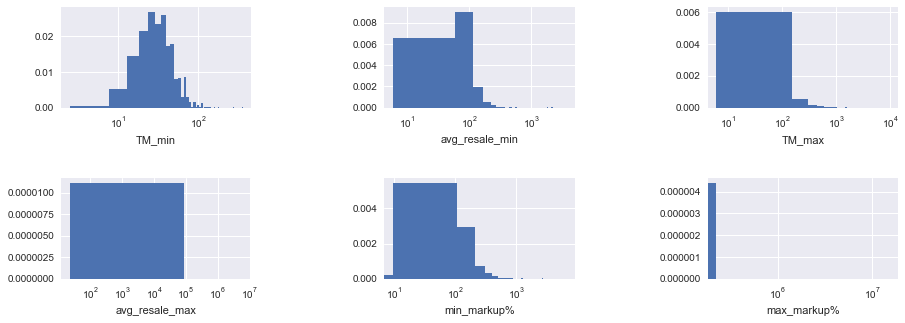

In [15]:
# Plot histogram of ticket prices

#Set initial subplot number
plot = 1

#Loop through each price column
for col in features['price_cols']:
    plt.subplot(2,3,plot)
    plt.hist(df[col].dropna(),
             bins = sqrt_bins(col),
             normed=True
            )
    plt.xlabel(col)
    plt.xscale('log')
    plot +=1
    
plt.subplots_adjust(hspace=.7,wspace=0.7)
plt.show()


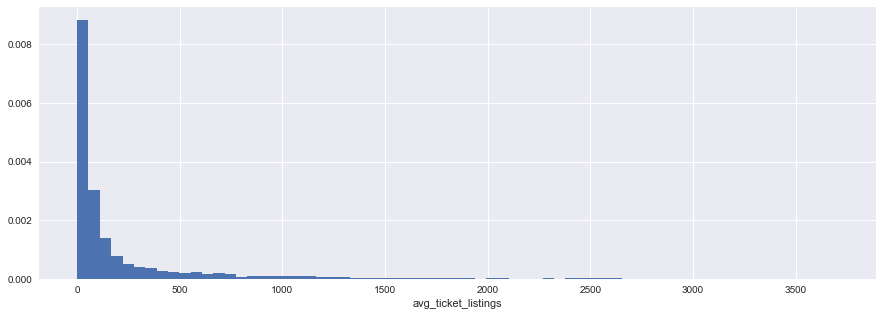

In [16]:
plt.hist(df['avg_ticket_listings'].dropna(), bins=sqrt_bins('avg_ticket_listings'),normed=True)
plt.xlabel('avg_ticket_listings')
plt.show()

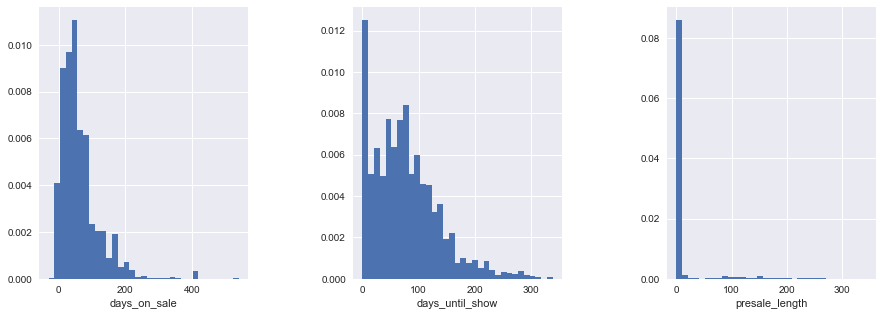

In [17]:
#Show histograms of time info
plot = 1
for col in features['time_cols']:
    plt.subplot(1,3,plot)
    plt.hist(df[col].dropna(),
             bins = rice_bins(col),
             normed=True)
    plt.xlabel(col)
    plot +=1
plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

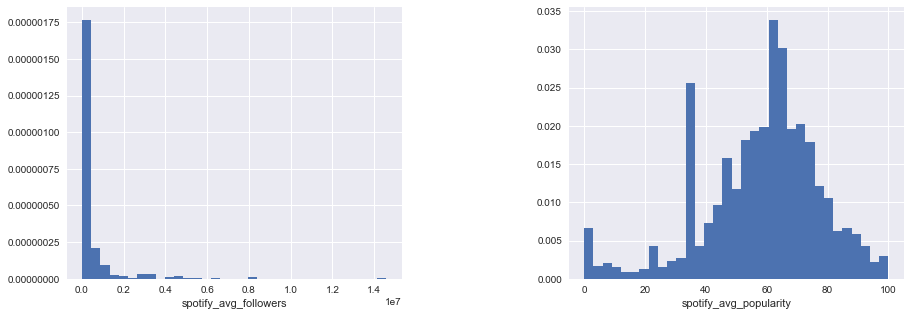

In [18]:
#Histograms of artist info
plot = 1
for col in features['artist_cols']:
    plt.subplot(1,2,plot)
    plt.hist(df[col],
             bins = rice_bins(col),
             normed=True)
    plt.xlabel(col)
    plot +=1
plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

## 2.1.3 ECDFs
    a. Define function
    b. Plot Ticket Price ECDFs (Normal Scale)
    c. Plot log scale ECDFs

In [19]:
#Define ECDF Function
def plot_ecdf(data,label,log_scale=0):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    
    #Make plot
    ecdf = plt.plot(x, y,label=label,marker='.',linestyle='none')

    if log_scale == 1:
        plt.xscale('log')
        plt.xlabel(label)
        plt.ylabel('ECDF')
        plt.ylim(ymax=1)
    else:
        plt.xlabel(label)
        plt.ylabel('ECDF')
        plt.ylim(ymax=1)
    return ecdf


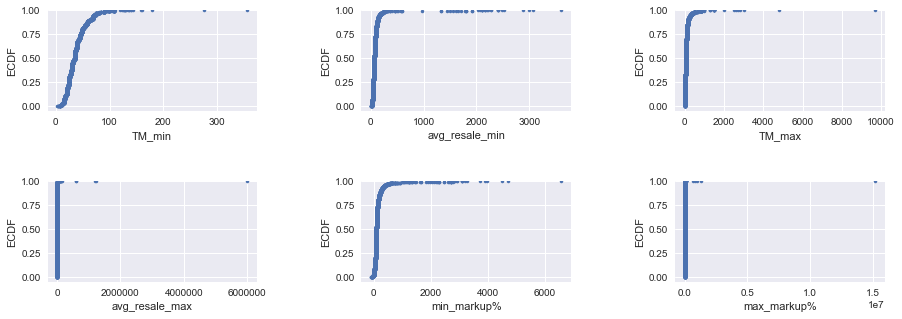

In [20]:
plot = 1
for col in features['price_cols']:
    plt.subplot(2,3,plot) 
    plot_ecdf(df[col],col)
    plot += 1

plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

#### Notes: 
There's a lot of variance in ticket prices, none of the columns follow a normal distribution. Next step is to take a look at the data on a log scale

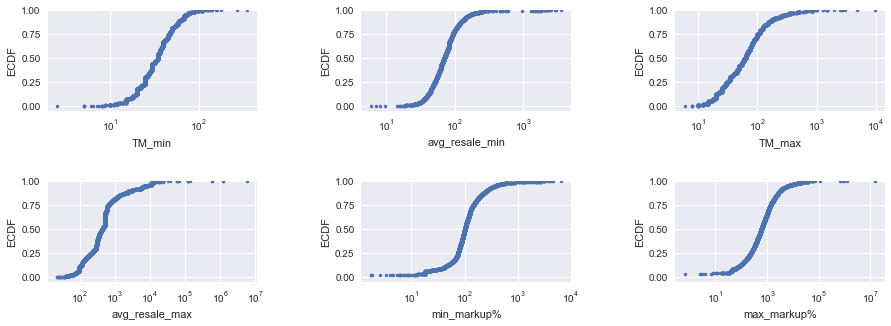

In [21]:
# Plot prices using log scale
plot = 1
for col in features['price_cols']:
    plt.subplot(2,3,plot) 
    plot_ecdf(df[col],col,1)
    plot += 1

plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.savefig('Graphs/log_price_ecdfs.png',format='PNG',bbox_inches='tight')


plt.show()

#### Notes: 
Though not quite normal, each of the ticket prices distributions much more closely resembles a normal distribution. 

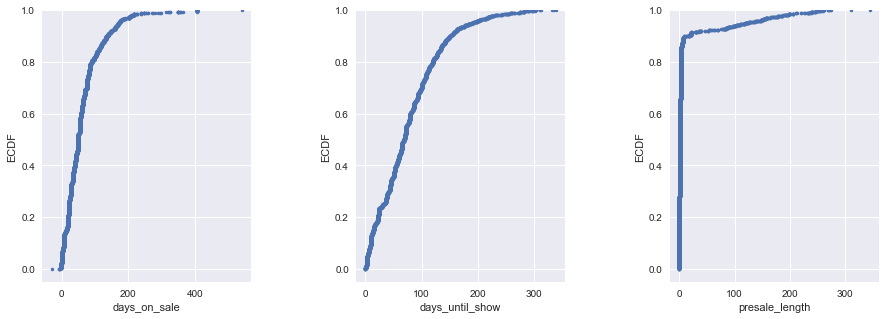

In [22]:
#ECDFs of time data
plot = 1
for col in features['time_cols']:
    plt.subplot(1,3,plot) 
    plot_ecdf(df[col].dropna(),col)
    plot += 1

plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

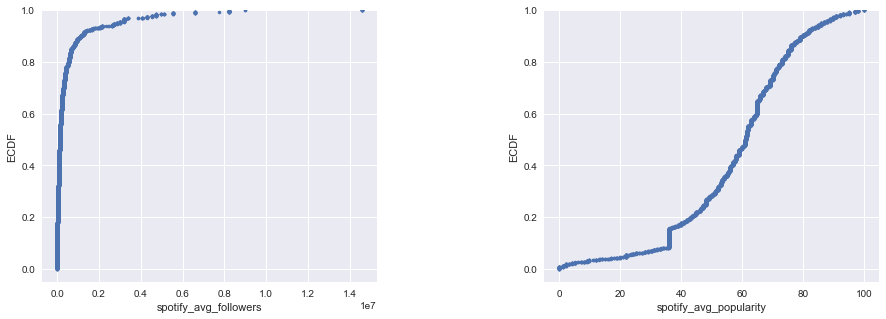

In [23]:
#ECDFs of artist data 

plot = 1
for col in features['artist_cols']:
    plt.subplot(1,2,plot) 
    plot_ecdf(df[col].dropna(),col)
    plot += 1

plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

## Conclusions & Questions:
    -Lots of outliers, especially among ticket prices maximums
    -Data should be transformed or outliers should be removed

# 2.1.4 Outlier Detection
    a. Define find_outlier function
    b. Count number of outliers
    c. Conclusions & questions
    
### a. Define functions
Detect outliers using Tukey method

In [24]:
def find_tukey_outliers(df, column,threshold=3):
    q1, q3 = df[column].quantile([.25,.75])
    iqr = np.subtract(q3,q1)
    lower_bound = q1 - (iqr * threshold)
    upper_bound = q3 + (iqr* threshold)
    return df.loc[(df[column] > upper_bound) | (df[column] < lower_bound)]

### b. Count number of outliers
 Count the number of outliers in ticket prices using Tukey threshold of 3x the IQR

In [25]:
# Number of minimum price outliers
min_price_outlier_list = list()
for col in features['price_cols'][0:2]:
    min_price_outlier_list.append(find_tukey_outliers(df,col))
min_outlier_df = pd.concat(min_price_outlier_list,axis=0)
min_outlier_df['TM_id'].nunique()

130

In [26]:
# Number of maximum price outliers
max_price_outlier_list = list()
for col in features['price_cols'][2:4]:
    max_price_outlier_list.append(find_tukey_outliers(df,col))
max_outlier_df = pd.concat(max_price_outlier_list,axis=0)
max_outlier_df['TM_id'].nunique()

670

###  c. Conclusion & questions
Removing all outliers would remove a significant amount of sample data. Since the data came directly from TIcketmaster, it is unlikely that outliers are due to any error. __I will keep the outliers for now and focus the analysis minimum ticket priecs, where there is less noise and variation.__

# 2.2 Categorical Features
     2.2.1 Countplots
            a. Events by state
            b. Events by genre
            c. Events by promoter
            d. Events by month
            e. Events with multiple days
     2.2.2 Conculsions and Questions
     2.2.3 Category Consolidation
 ## 2.2.1 Countplots 

### a. Events by State

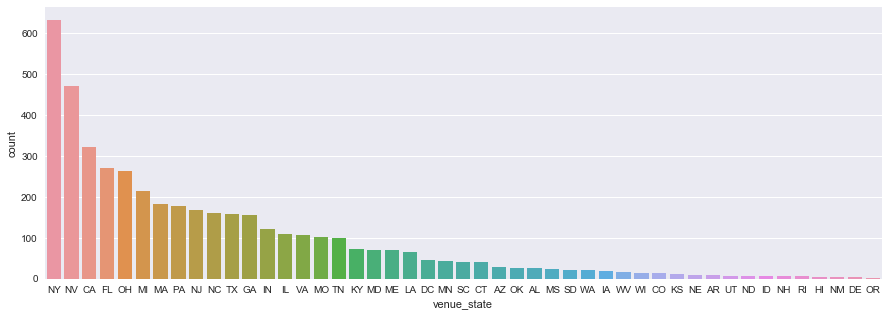

In [27]:
#Events by State
sns.countplot(data=df,x='venue_state', order = df['venue_state'].value_counts().index)
plt.show()

### b. Events by genre & subGenre

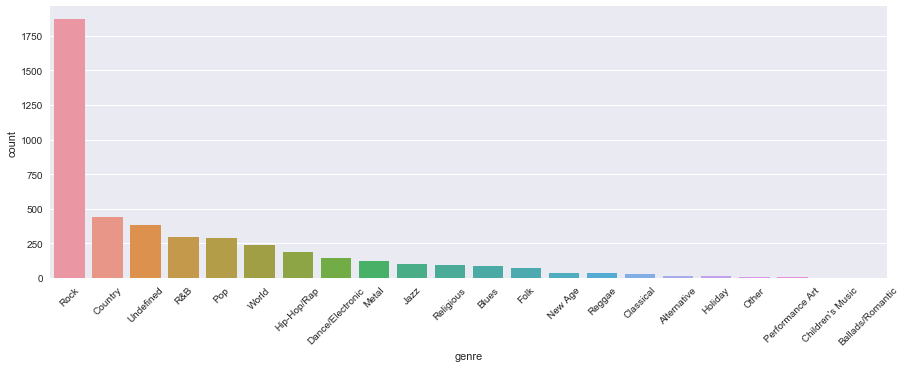

In [28]:
#Events by genre
sns.countplot(x='genre',data=df,order=df['genre'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

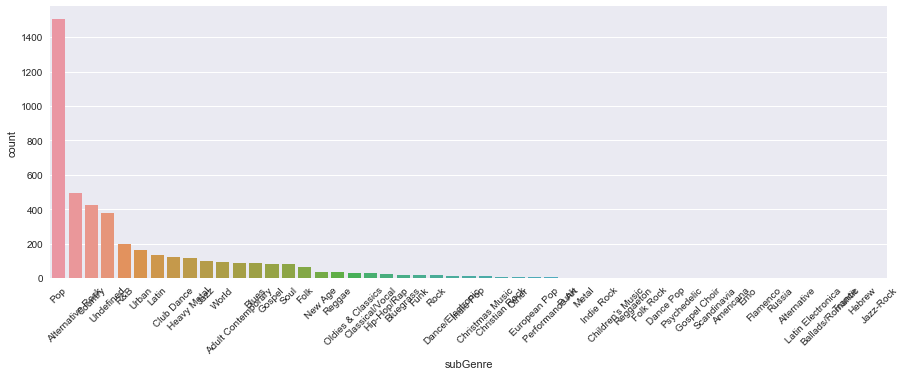

In [29]:
sns.countplot('subGenre',data=df,order=df['subGenre'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

### c. Events by promoter

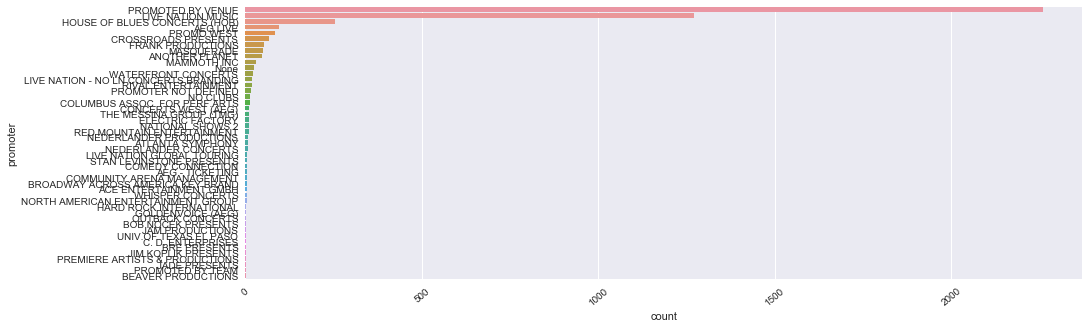

In [30]:
# Events by promoter
sns.countplot(y='promoter',data=df,order=df['promoter'].value_counts().index)
plt.xticks(rotation=40)
plt.show()

### d. Events by Month

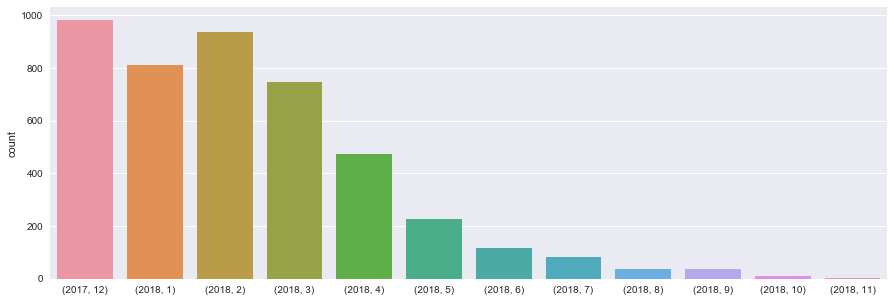

In [31]:
#Create list of Year & Months
year_month = list(zip(df["date"].dt.year, df["date"].dt.month))
# Sort by year, then month, convert to series for plotting
year_month = pd.Series(sorted(year_month,key=lambda x: (x[0], x[1])))

#Events by month
sns.countplot(year_month)
plt.show()

### e. Events by weekday

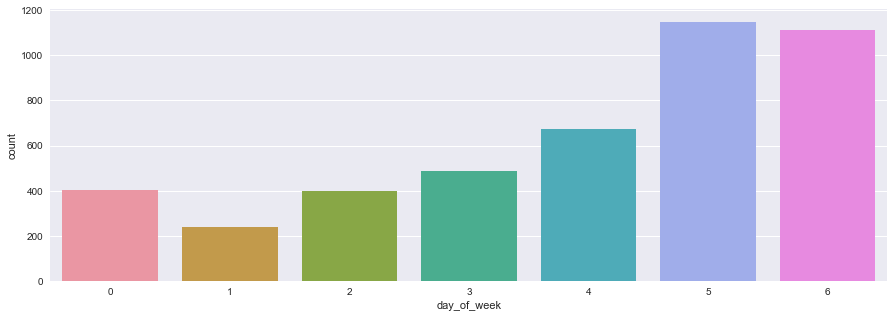

In [32]:
sns.countplot('day_of_week',data=df)
plt.show()

### f. Events by length

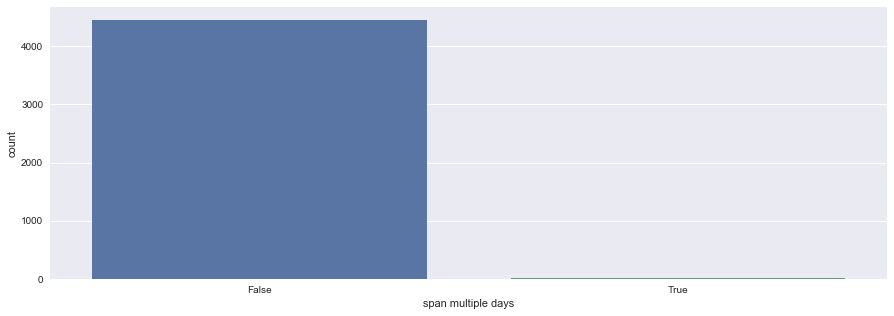

In [33]:
sns.countplot(x='span multiple days',data=df)
plt.show()

### g. Tickets by source

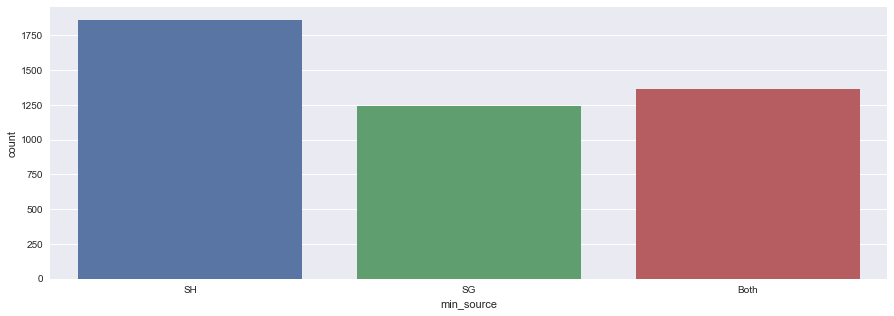

In [34]:
sns.countplot(x='min_source',data=df)
plt.show()

### h. Number of artists

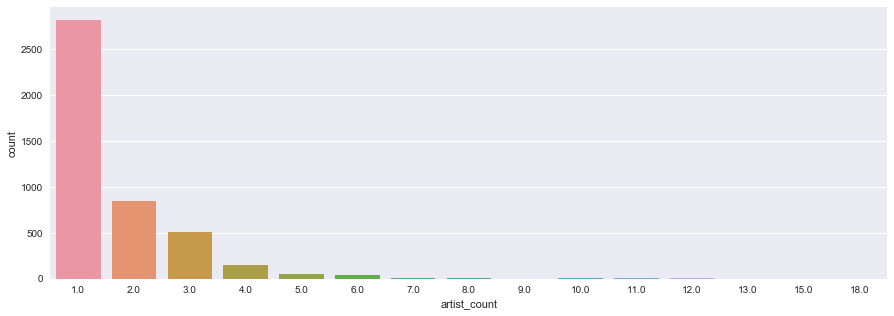

In [35]:
sns.countplot(x='artist_count',data=df)
plt.show()

## 2.2.2 Conclusions
There are several categories with sparse information. To avoid overfitting, I'll remove events from states with fewer than 50 events, and consolidate genres and promoters with only a few events into 'Other'. </br>
There are also significantly fewer listings after May 2018. It seems unlikely that I'll be able to predict prices for events far into the future with a small sample size, so I will remove those as well. 

## 2.2.3 Category Consolidation
1. Remove states that have only a few events (Threshold = 50) </br>
2. Relabel genres with only a few events to 'Other'</br>
3. Remove events after May 2018</br>

In [36]:
#Create masks to filter out categories with value counts less than threshold
thresh = 50 
genre_mask = df.genre.value_counts()
subGenre_mask = df.subGenre.value_counts()
promoter_mask = df.promoter.value_counts()
genre_dict = {element :'Other' for element in genre_mask[genre_mask < thresh].index}
subGenre_dict = {element :'Other' for element in subGenre_mask[subGenre_mask < thresh].index}
promoter_dict = {element :'Other' for element in promoter_mask[promoter_mask < thresh].index}
state_mask = df['venue_state'].value_counts()
date_mask = datetime.datetime(2018,6,1)

# Make a new df for consolidated data
reg_df = df[(df.venue_state.isin(state_mask[state_mask > thresh].index)) & (df.date < date_mask)]

reg_df.loc[reg_df.genre.isin(genre_dict.keys()),'genre'] = \
    df.genre.map(genre_dict)
    
reg_df.loc[reg_df.subGenre.isin(subGenre_dict.keys()),'subGenre'] = \
    df.subGenre.map(subGenre_dict)
    
reg_df.loc[reg_df.promoter.isin(promoter_dict.keys()),'promoter'] = \
    df.promoter.map(promoter_dict)
reg_df.shape

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(3757, 46)

# 3 Data Exploration
    3.1 Scatterplots (Spotify info, SeatGeek venue score, ticket listings, time info)
        3.1.1 Venue Score notes
    3.2 Venue State
    3.3 Day of Week
    3.4 Genre and Subgenre
    3.5 Artist count
    3.6 Promoter
    3.7 Resale Ticket Source
    
## 3.1 Scatterplots

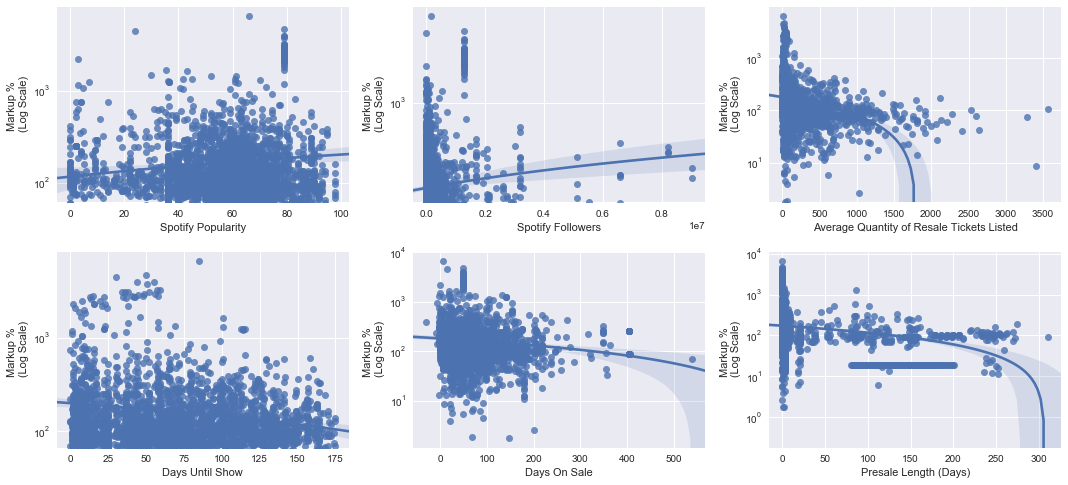

In [37]:
plt.figure(figsize=(15,10))
plt.subplot(331)
sns.regplot('spotify_avg_popularity','min_markup%',data=reg_df)
plt.ylabel("Markup % \n (Log Scale)")
plt.yscale('log')
plt.xlabel("Spotify Popularity")

plt.subplot(332)
sns.regplot('spotify_avg_followers','min_markup%',data=reg_df)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.xlabel("Spotify Followers")

plt.subplot(333)
sns.regplot('avg_ticket_listings','min_markup%',data=reg_df)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.xlabel("Average Quantity of Resale Tickets Listed")

plt.subplot(334)
sns.regplot('days_until_show','min_markup%',data=reg_df)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.xlabel("Days Until Show")

plt.subplot(335)
sns.regplot('days_on_sale','min_markup%',data=reg_df)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.xlabel("Days On Sale")

plt.subplot(336)
sns.regplot('presale_length','min_markup%',data=reg_df)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.xlabel("Presale Length (Days)")

plt.subplots_adjust(hspace=.5)

plt.tight_layout()

plt.savefig('Graphs/continuous_scatterplots.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes

These scatterplots tell us several things:<br>
    1. There is a positive correlation betweeen spotify popularity/followers and markup
    2. There is a slight negative correlation between number of resale tickets listed, and markup
    3. There appears to be a negative correlation between days until show/days on sale/presale length and the ticket markup.

## 3.1 Venue State

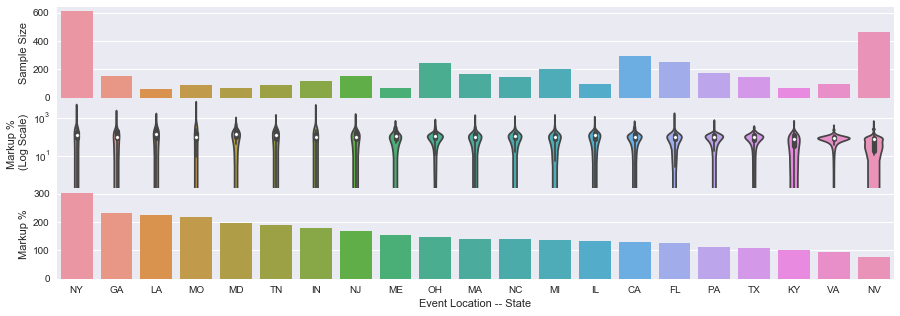

In [38]:
state_markup = reg_df[['venue_state','min_markup%']].groupby('venue_state').mean().sort_values(by=
                                                                            'min_markup%',
                                                                           ascending=False)
plt.subplot(311)
sns.countplot(x='venue_state',data=reg_df,order=state_markup.index)
plt.ylabel("Sample Size")
plt.subplot(312)
sns.violinplot(x='venue_state',y='min_markup%',data=reg_df,order=state_markup.index)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.subplot(313)
sns.barplot(x=state_markup.index,y='min_markup%',data=state_markup)
plt.ylabel("Markup %")
plt.xlabel("Event Location -- State")
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/state_summary.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes 
There doesn't seem to be any obvious connection between ticket markup and state. Tickets in states with low costs of living such as GA, LA, and MO have some of the highest average markups, whereas prices in CA are comparable to IL and FL. <br>

In addition, NY and NV have the count of the most events, but are on completely opposite ends of the markup spectrum

## 3.2 Day of week

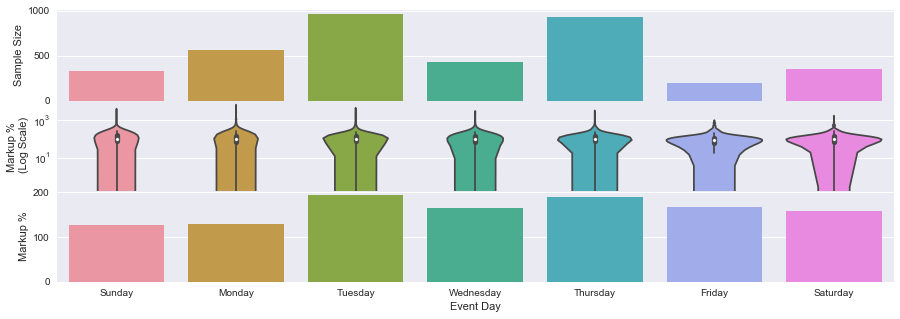

In [39]:
day_markup = reg_df[['day_of_week','min_markup%']].groupby('day_of_week').mean().sort_values(by=
                                                                            'min_markup%',
                                                                           ascending=False)
plt.subplot(311)
sns.countplot(x='day_of_week',data=reg_df,order=day_markup.index)
plt.ylabel("Sample Size")
plt.subplot(312)
sns.violinplot(x='day_of_week',y='min_markup%',data=reg_df,order=day_markup.index)
plt.ylabel("Markup % \n (Log Scale)")
plt.yscale('log')
plt.subplot(313)
fig = sns.barplot(x=day_markup.index,y='min_markup%',data=day_markup)
plt.ylabel("Markup %")
fig.set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.xlabel('Event Day')
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/day_summary.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes

Interestingly, shows on Wednesday have the similar markups to weekend shows. However, weekend ticket prices aggregate around the mean in compared to weekday events, where markups appear more evenly distributed

## 3.3 Genre & Subgenre

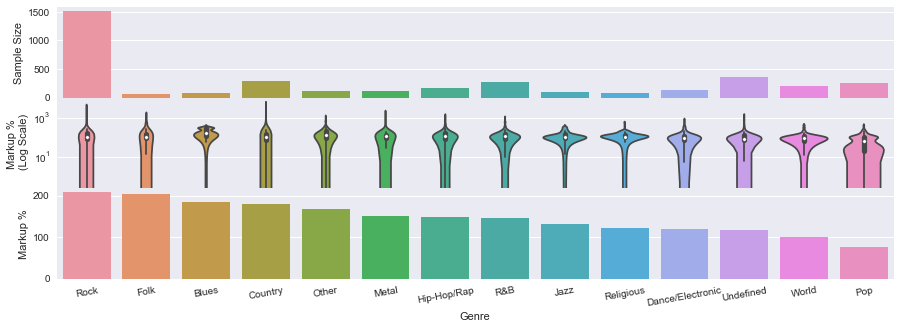

In [40]:
genre_markup = reg_df[['genre','min_markup%']].groupby(['genre',]).mean().sort_values(by=
                                                                            'min_markup%',
                                                                           ascending=False)
plt.subplot(311)
sns.countplot(x='genre',data=reg_df,order=genre_markup.index)
plt.ylabel("Sample Size")
plt.subplot(312)
sns.violinplot(x='genre',y='min_markup%',data=reg_df,inner='box',order=genre_markup.index)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")

plt.subplot(313)
sns.barplot(x=genre_markup.index,y='min_markup%',data=genre_markup)
plt.xticks(rotation=10)
plt.ylabel("Markup %")
plt.xlabel("Genre")
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/genre_summary.png',format='PNG',bbox_inches='tight')
plt.show()

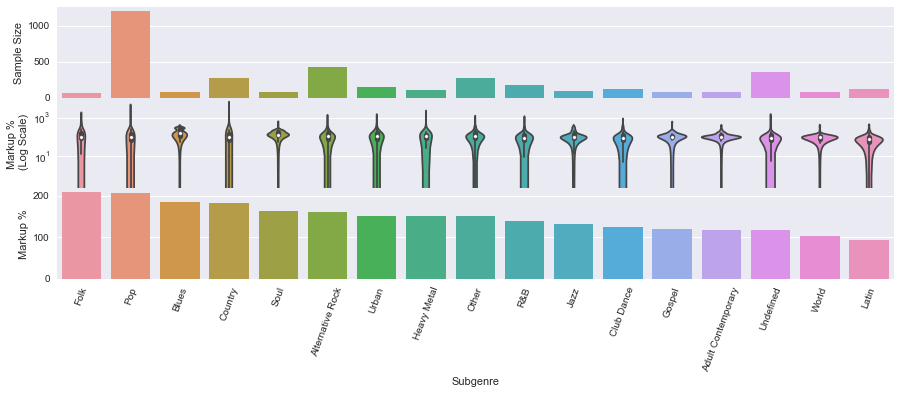

In [41]:
subGenre_markup = reg_df[['subGenre','min_markup%']].groupby('subGenre').mean().sort_values(by=
                                                                            'min_markup%',
                                                                           ascending=False)
plt.subplot(311)
sns.countplot(x='subGenre',data=reg_df,order=subGenre_markup.index)
plt.ylabel("Sample Size")
plt.subplot(312)
sns.violinplot(x='subGenre',y='min_markup%',data=reg_df,order=subGenre_markup.index)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.subplot(313)
sns.barplot(x=subGenre_markup.index,y='min_markup%',data=subGenre_markup)
plt.xticks(rotation=10)
plt.ylabel("Markup %")
plt.xlabel("Subgenre")
plt.xticks(rotation = 70)
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/subgenre_summary.png',format='PNG',bbox_inches='tight')
plt.show()

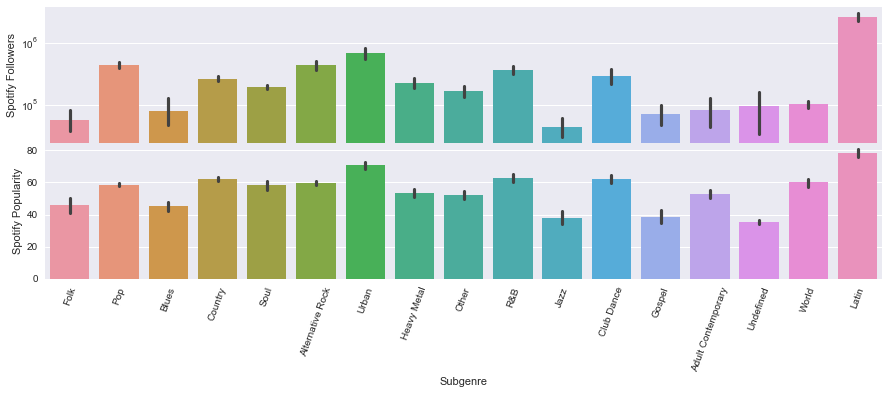

In [42]:

fig = plt.figure(figsize=(15,5))
plt.subplot(211)
sns.barplot(x='subGenre',y='spotify_avg_followers',data=reg_df,order=subGenre_markup.index)
plt.ylabel('Spotify Followers')
plt.yscale('log')
plt.subplot(212)
sns.barplot(x='subGenre',y='spotify_avg_popularity',data=reg_df,order=subGenre_markup.index)
plt.ylabel('Spotify Popularity')
plt.xlabel("Subgenre")
plt.xticks(rotation = 70)
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/subgenre_spotify_summary.png',format='PNG',bbox_inches='tight')
plt.show()

In [43]:
pd.crosstab(reg_df['genre'],
            reg_df['subGenre'],
            values=reg_df['TM_id'],
            normalize='columns',
            aggfunc='count')

subGenre,Adult Contemporary,Alternative Rock,Blues,Club Dance,Country,Folk,Gospel,Heavy Metal,Jazz,Latin,Other,Pop,R&B,Soul,Undefined,Urban,World
genre,,,,,,,,,,,,,,,,,
Blues,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
Country,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064748,0.00000,0.0,0.0,0.0,0.0,0.0
Dance/Electronic,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057554,0.00000,0.0,0.0,0.0,0.0,0.0
Folk,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.010791,0.00000,0.0,0.0,0.0,0.0,0.0
Hip-Hop/Rap,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079137,0.00000,0.0,0.0,0.0,1.0,0.0
Jazz,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
Metal,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.014388,0.00000,0.0,0.0,0.0,0.0,0.0
Other,0.0,0.018779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.410072,0.00000,0.0,0.0,0.0,0.0,0.0
Pop,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050360,0.13606,0.0,0.0,0.0,0.0,0.0


### Notes

Markups on pop and rock events much more evenly distributed compared to genres like Blues, Religious, Jazz, and World which are centered around the mean. I also disagree with Ticketmasters genres on some artists. Artists like Katy Perry, Cashmere Cat and Lana del Rey are categorized as rock. I believe that the subGenre classifier is much more representative of each artist's style of music than the genre classifier

## 3.4 Artist Count

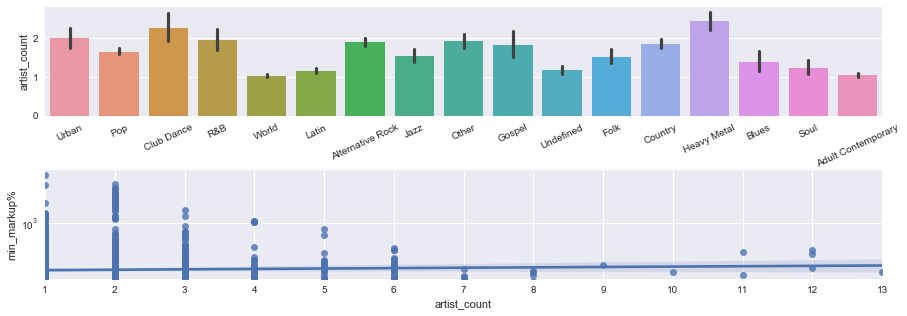

In [44]:
plt.subplot(211)
sns.barplot(x='subGenre',y='artist_count',data=reg_df)
plt.xticks(rotation=25)
plt.subplot(212)
sns.regplot(x='artist_count',y='min_markup%',data=reg_df)
plt.yscale('log')
plt.xticks(np.arange(0,max(reg_df['artist_count']),1))
plt.xlim(xmin=1,xmax=13)
plt.subplots_adjust(hspace=.5)
plt.savefig('Graphs/artistcount_subgenre.png',format='PNG',bbox_inches='tight')
plt.show()

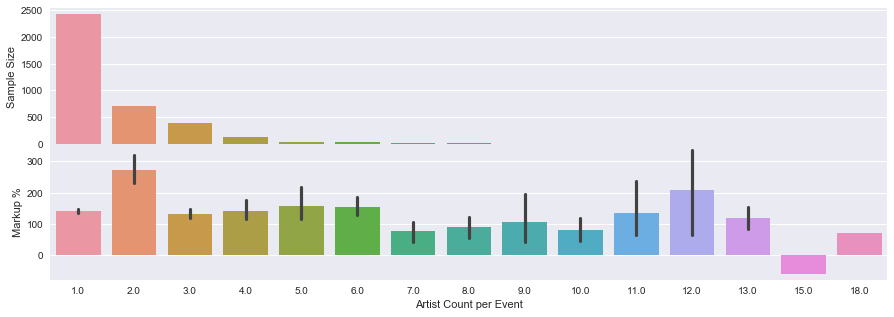

In [45]:
plt.subplot(211)
sns.countplot(x='artist_count',data=reg_df)
plt.xticks(rotation=25)
plt.ylabel("Sample Size")
plt.subplot(212)
sns.barplot(x='artist_count',y='min_markup%',data=reg_df)
plt.ylabel("Markup %")
plt.xlabel("Artist Count per Event")
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/artistcount_summary.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes
No clear correlation beween number of artists performing, and markup prices

## 3.5 Promoters

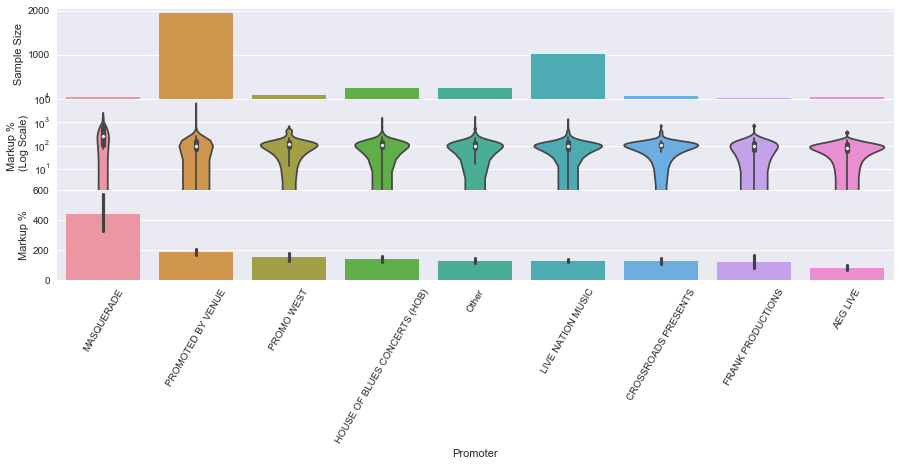

In [46]:
promoter_markup = reg_df[['promoter','min_markup%']].groupby('promoter').mean().sort_values(by=
                                                                            'min_markup%',
                                                                           ascending=False)

plt.subplot(311)
sns.countplot(x='promoter',data=reg_df,order=promoter_markup.index)
plt.ylabel("Sample Size")
plt.subplot(312)
sns.violinplot(x='promoter',y='min_markup%',data=reg_df,order=promoter_markup.index)
plt.yscale('log')
plt.ylabel("Markup % \n (Log Scale)")
plt.subplot(313)
sns.barplot(x='promoter',y='min_markup%',data=reg_df,order=promoter_markup.index)
plt.xticks(rotation=60)
plt.ylabel("Markup %")
plt.xlabel("Promoter")
plt.subplots_adjust(hspace=0)
plt.savefig('Graphs/promoter_summary.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes
Masquerade is a venue and tour promoter based in Atlanta GA. Venue-promoted events drive the highest markups compared to any specific company.

## 3.6 Ticket Markups by Source

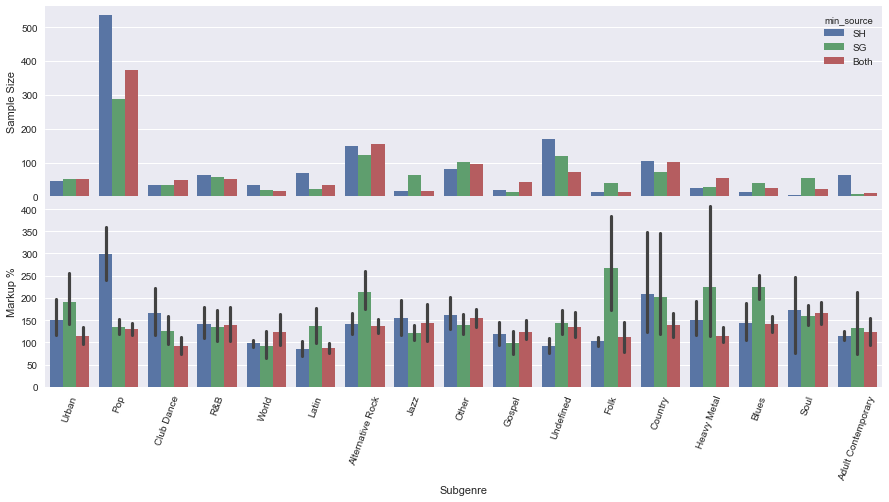

In [47]:
fig = plt.figure(figsize=(15,7))
plt.subplot(211)
ax = sns.countplot(x='subGenre',hue='min_source',data=reg_df)
plt.ylabel("Sample Size")
ax.set_xticklabels([])
plt.subplot(212)
ax1 = sns.barplot(x='subGenre',y='min_markup%',hue='min_source',data=reg_df)
plt.ylabel("Markup %")
plt.xlabel("Subgenre")
plt.xticks(rotation = 70)
ax1.legend_.remove()
plt.subplots_adjust(hspace=0)
plt.show()

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

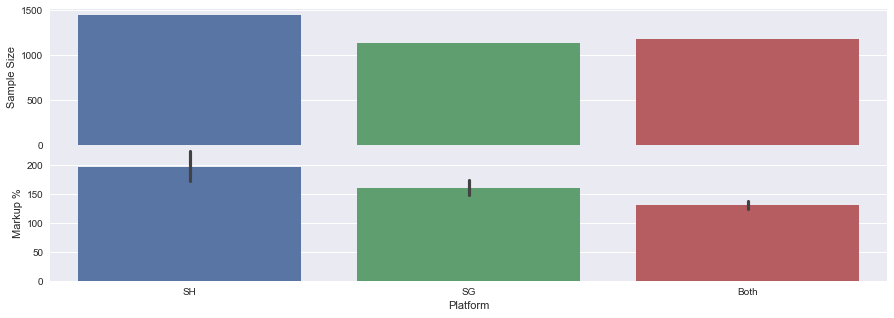

In [50]:
plt.subplot(211)
sns.countplot(x='min_source',data=reg_df)
plt.ylabel("Sample Size")
plt.subplot(212)
sns.barplot(x='min_source',y='min_markup%',data=reg_df)
plt.subplots_adjust(hspace=0)
plt.ylabel("Markup %")
plt.xlabel("Platform")
plt.xtickl(['Stubhub','SeatGeek','Both'])
plt.savefig('Graphs/source_summary.png',format='PNG',bbox_inches='tight')
plt.show()

### Notes
Markups are much higher on SeatGeek for Alternative Rock, Folk, Blues.<br>
Markups are much higher on Stubhub for Pop and Club Dance.

Stubhub markups are more evenly distributed than those on SeatGeek, which aggregate around the mean. 

In [49]:
#Save DF to csv and pickle
df.to_csv('Data/cleaned_df.csv',index=False)
reg_df.to_csv('Data/output_df.csv',index=False)

df.to_pickle('Pickles/cleaned_df.pkl')
reg_df.to_pickle('Pickles/output_df.pkl')